# 背景概述

$\quad$你喜欢吃披萨吗😍? 不管你喜欢与否, 都欢迎完成本次上机作业! 我们将构建一个基于卷积网络的二元分类器, 用于识别给定的一张图片是否是披萨的照片.

$\quad$如果希望前期模型训练和数据集拆分的结果具有 **可复现性** (reproducibility), 请运行下述的代码块, 设置随机数种子.

In [49]:
import lightning as L

L.pytorch.seed_everything(42, workers=True)

Seed set to 42


42

# 数据清洗与可视化

$\quad$我们将使用的数据集为`pizza_or_not`, 包含两个子目录. 子目录`pizza`存有983张披萨 (阳性) 的照片, 子目录`not_pizza`存有983张其他种类食物 (阴性) 的照片. 每张照片尺寸不一, 但均为彩照, 即含有三个色彩通道 (采用[YUV色彩空间](https://dexonsystems.com/blog/rgb-yuv-color-spaces)).

In [50]:
import os
from pathlib import Path
import PIL
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose

class PizzaOrNotDataset(Dataset):
    def __init__(self, root: str, transform: Compose):
        super().__init__()
        self.positive_img_fnames = [str(child.resolve()) for child in Path.iterdir(Path(os.path.join(root, 'pizza')))]
        self.negative_img_fnames = [str(child.resolve()) for child in Path.iterdir(Path(os.path.join(root, 'not_pizza')))]
        self.transform = transform
    @property
    def n_positive_imgs(self):
        return len(self.positive_img_fnames)
    @property
    def n_negative_imgs(self):
        return len(self.negative_img_fnames)
    def __len__(self):
        return self.n_positive_imgs + self.n_negative_imgs
    def __getitem__(self, idx):
        if 0 <= idx < self.n_positive_imgs:
            img = self.transform(PIL.Image.open(self.positive_img_fnames[idx]))
            label = torch.tensor(1).float()
        else:
            img = self.transform(PIL.Image.open(self.negative_img_fnames[idx - self.n_positive_imgs]))
            label = torch.tensor(0).float()
        return (img, label)

$\quad$**任务1**: 根据数据集`PizzaOrNotDataset`, 将数据模块`PizzaOrNotDataModule`中的`setup()`方法补充完整. 使得
- 当`stage == 'fit'` **或** `stage == 'validate'`时, 根据已有的类属性`train_idxs`与`val_idxs`, 设置好类属性`train_dataset` **与** `val_dataset`备用;
- 当`stage == 'test'`时, 根据已有的类属性`test_idxs`, 设置好类属性`test_dataset`备用.

其中, 每个数据集都是一个二元元组的列表, 每个二元元组 (数据样本) 分别存储特征和标签.

### 提示

- 与上机实习3.1不同, 我们的数据集需要自定义为[`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)的派生类, 代码已经直接给出. 相比于其它的数据组织形式, 这更有利于的内存节约.
  - 对给定的数据集与索引列表, 我们使用[`torch.utils.data.Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset)可以很方便地建立数据子集.
- 访问类属性时需要加前缀`self.`, 例如`self.transform`.
- 多条件匹配可使用[`case-match`语句](https://docs.python.org/3/tutorial/controlflow.html#match-statements).

In [51]:
from collections.abc import Iterable
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Subset

class PizzaOrNotDataModule(L.LightningDataModule):
    def __init__(
        self, root: str, transform: Compose, train_idxs: Iterable[int], val_idxs: Iterable[int]=None, test_idxs: Iterable[int]=None, batch_size: int=16
    ):
        super().__init__()
        self.full_dataset = PizzaOrNotDataset(root, transform)
        self.train_idxs = train_idxs
        self.val_idxs = val_idxs
        self.test_idxs = test_idxs
        self.batch_size = batch_size
    def setup(self, stage: str):
        ### BEGIN YOUR SOLUTION ###
        if stage == 'fit' or stage == 'validate':
            self.train_dataset = Subset(self.full_dataset, self.train_idxs)
            self.val_dataset = Subset(self.full_dataset, self.val_idxs)
        elif stage == 'test':
            self.test_dataset = Subset(self.full_dataset, self.test_idxs)
        else:
            raise ValueError(f"Unknown stage: {stage}")
        ### END YOUR SOLUTION ###
    def visualize_train_data(self, n_samples: int, n_rows: int):
        plt.figure(figsize=(10, 3))
        samples = [self.train_dataset[idx] for idx in range(n_samples)]
        for i, sample in enumerate(samples):
            img, label = sample
            plt.subplot(n_rows, n_samples // n_rows, i + 1)
            plt.imshow(img.permute((1, 2, 0)).numpy(), interpolation='none')
            plt.title(f'label: {int(label)}')
            plt.axis('off')
        plt.show()
    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size)
    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val_dataset, batch_size=len(self.val_dataset))
    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_dataset, batch_size=len(self.test_dataset))

$\quad$完成任务1后, 请运行下面的代码块进行初步检查与部分样本的可视化. Hmmm! 怎么样, 有没有心动的一款😋!
- 我们定义的图像变换操作流是:
  - 格式转换为`Tensor` (同时, `PyTorch`会自动将每个像素值作重标度, 除以255);
  - 图片的大小调整为128x128, 即总共16384个像素.

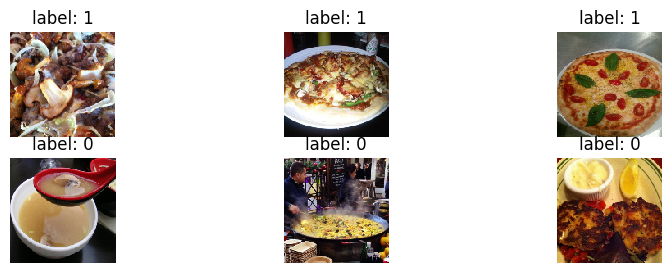

In [52]:
from torchvision.transforms import ToTensor, Resize

datamodule_viz = PizzaOrNotDataModule(
    root='data',
    transform=Compose([ToTensor(), Resize((128, 128), antialias=False)]),
    train_idxs=[300 * i for i in range(1, 7)]
)
datamodule_viz.prepare_data()
datamodule_viz.setup(stage='fit')
datamodule_viz.visualize_train_data(n_samples=6, n_rows=2)

# 模型的搭建

$\quad$我们搭建的模型架构如下图所示. 这是一个卷积网络+全连接网络的架构, 其中, 卷积模块`ConvModule`包含两组卷积-最大池化操作, 并且第二次的卷积核有所扩张, 以提取更广域的像素信息. 图中默认采用3x3卷积核, 这个大小将在稍后作为模型超参数进行调整.

![alt](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/c7ebd9ccf7ce4af6a3d85937597b4daf/0553ad3d-fb44-43f7-bf50-b24aa9437c32.png)


$\quad$**任务2**: 为模型编写两个 (底层) 模块`PizzaOrNotConvModule`和`PizzaOrNotFCNNModule`. 它们都是[`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module)的派生类, 你需要各自实现如下两个方法:
- `__init__()`方法, 以类属性的形式定义必要的组件和层;
- `forward()`方法, 给出前向传播的输出.

### 提示

- 由于这些模块都是`nn.Module`的派生类, 因此它们的构造函数`__init__()`的第一行语句必须是
```python
super().__init__()
```
- 请查阅[`torch.nn`](https://pytorch.org/docs/stable/nn.html#module-torch.nn)模块的官方文档, 自行搜索你所需的组件及参数.

In [53]:
from torch import nn

class PizzaOrNotConvModule(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        ### BEGIN YOUR SOLUTION ###
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=kernel_size, dilation=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=kernel_size, dilation=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=4),
        )
        ### END YOUR SOLUTION ###
    def forward(self, X):
        ### BEGIN YOUR SOLUTION ###
        return self.conv_block(X)
        ### END YOUR SOLUTION ###

In [54]:
from typing import Sequence

class PizzaOrNotFCNNModule(nn.Module):
    def __init__(self, num_inputs: int=2048, num_hiddens: int=128, num_outputs: int=1):
        ### BEGIN YOUR SOLUTION ###
        super().__init__()
        self.fc_block = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs),
        )
        ### END YOUR SOLUTION ###
    def forward(self, x):
        ### BEGIN YOUR SOLUTION ###
        x = x.flatten(start_dim=1)
        return self.fc_block(x)   
        ### END YOUR SOLUTION ###

$\quad$完成任务2后, 请运行下面两个代码块, 完成模型组装与初步检查.

In [55]:
from torch import optim
from torchmetrics import Accuracy, Precision, Recall, F1Score

class PizzaOrNotModule(L.LightningModule):
    def __init__(self, conv_module, fcnn_module, lr: float=0.001, weight_decay: float=0.0):
        super().__init__()
        self.conv_module = conv_module
        self.fcnn_module = fcnn_module
        self.loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
        # metrics
        self.metrics = {
            'acc': Accuracy(task='binary'),
            'precision': Precision(task='binary'),
            'recall': Recall(task='binary'),
            'f1': F1Score(task='binary')
        }
        # hyperparameters
        self.lr = lr
        self.weight_decay = weight_decay
    def forward(self, X):
        return self.fcnn_module(self.conv_module(X).view(X.size(0), -1)).squeeze()
    def training_step(self, batch, batch_idx):
        X, y_true = batch
        y_output = self.forward(X)
        loss = self.loss_fn(y_output, y_true)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
    def validation_step(self, batch, batch_idx):
        X, y_true = batch
        y_output = self.forward(X)
        acc = self.metrics['acc'](y_output, y_true)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
    def test_step(self, batch, batch_idx):
        X, y_true = batch
        y_output = self.forward(X)
        for key, value in self.metrics.items():
            metric = value(y_output, y_true)
            self.log(f'test_{key}', metric)
    def configure_optimizers(self) -> optim.Optimizer:
        return optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

In [56]:
pizza_or_not_conv_module = PizzaOrNotConvModule()
pizza_or_not_fcnn_module = PizzaOrNotFCNNModule()
pizza_or_not_module = PizzaOrNotModule(pizza_or_not_conv_module, pizza_or_not_fcnn_module)
print(pizza_or_not_module)

PizzaOrNotModule(
  (conv_module): PizzaOrNotConvModule(
    (conv_block): Sequential(
      (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(3, 3))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fcnn_module): PizzaOrNotFCNNModule(
    (fc_block): Sequential(
      (0): Linear(in_features=2048, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (loss_fn): BCEWithLogitsLoss()
)


# 超参数的组合优化

$\quad$首先, 请运行下面的4个代码块, 以检查数据与模型是否都能正常工作.

In [57]:
from lightning.pytorch.loggers import CSVLogger
from torch.utils.data import random_split

train_idxs, val_idxs, test_idxs = random_split(range(1966), [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))
sanity_check_datamodule = PizzaOrNotDataModule(
    root='data',
    transform=Compose([ToTensor(), Resize((128, 128), antialias=False)]),
    train_idxs=train_idxs, val_idxs=val_idxs, test_idxs=test_idxs
)
logger = CSVLogger(save_dir='logs', name='sanity_check')
trainer = L.Trainer(max_epochs=2, logger=logger, accelerator='auto', deterministic=True)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [58]:
trainer.fit(model=pizza_or_not_module, datamodule=sanity_check_datamodule)


  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 408    | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.051     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\track\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


c:\Users\track\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 99/99 [00:10<00:00,  9.10it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 99/99 [00:10<00:00,  9.07it/s, v_num=4]


In [59]:
trainer.validate(model=pizza_or_not_module, datamodule=sanity_check_datamodule, verbose=False)[0]

Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


{'val_acc': 0.6548223495483398}

In [60]:
trainer.test(model=pizza_or_not_module, datamodule=sanity_check_datamodule, verbose=False)[0]

c:\Users\track\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s]


{'test_acc': 0.6479591727256775,
 'test_precision': 0.7820512652397156,
 'test_recall': 0.5398229956626892,
 'test_f1': 0.6387434601783752}

$\quad$检查完成后, 请运行下述代码块, 定义交叉验证函数`cross_validation()`备用. 其中, 我们指定训练轮次为5.
- 注意: 这里我们将`model`显式地传入, 从而只考虑`batch_size`这一个 (待优化的) 模型超参数. 这种封装相比于上机实习3.1所呈现的封装方法更合理, 因为交叉验证是关于 **数据集** 的操作.

In [61]:
from sklearn.model_selection import KFold

def cross_validation(
    model: L.LightningModule, train_val_idxs: Sequence[int], batch_size: int, n_splits: int=3, max_epochs: int=5
) -> float:
    kf = KFold(n_splits=n_splits)
    accs = []
    for train, val in kf.split(train_val_idxs):
        train_idxs, val_idxs = [train_val_idxs[t] for t in train], [train_val_idxs[v] for v in val]
        # basic setup
        datamodule = PizzaOrNotDataModule(
            root='data',
            transform=Compose([ToTensor(), Resize((128, 128), antialias=False)]),
            train_idxs=train_idxs, val_idxs=val_idxs, batch_size=batch_size
        )
        logger = CSVLogger(save_dir='logs', name='tune_cv')
        # training stage
        trainer = L.Trainer(max_epochs=max_epochs, logger=logger, accelerator='auto', deterministic=True)
        trainer.fit(model, datamodule)
        # validation stage
        acc = trainer.validate(model, datamodule, verbose=False)[0]
        accs.append(acc['val_acc'])
    return sum(accs) / len(accs)

$\quad$现在, 我们使用`Optuna`完成超参数优化.

$\quad$**任务3**: 编写`Optuna`库所要求的目标函数`objective`, 实现训练集上的3折交叉验证, 返回 **(平均) 验证集准确率** 作为优化指标. 超参数搜索空间为:
- 数据批次大小`batch_size`: 在32、64、128中等概率地随机抽取;
- 卷积核大小`kernel_size`: 在3、5中等概率地随机抽取;
- 学习率`lr`: 在$10^{-3} \sim 10^{-1}$区间内的均匀对数分布中抽取;
- $L_2$范数正则化强度`weight_decay`: 在$10^{-4} \sim 10^{-2}$区间内的均匀对数分布中抽取.

### 提示

- 记得用好已经给出的函数`cross_validation()`, 只要你的输入是正确合理的, 它将直接返回你需要的优化指标.

In [62]:
train_val_idxs, test_idxs = random_split(range(1966), [0.7, 0.3], generator=torch.Generator().manual_seed(42))
n_splits = 3

from optuna import Trial
def objective(trial: Trial) -> float:
    ### BEGIN YOUR SOLUTION ###
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
    lr = trial.suggest_float('lr', 1e-3, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
    # create model with sampled hyperparameters
    conv = PizzaOrNotConvModule(kernel_size=kernel_size)
    fcnn = PizzaOrNotFCNNModule()
    model = PizzaOrNotModule(conv, fcnn, lr=lr, weight_decay=weight_decay)
    # run cross-validation and return average validation accuracy
    val_acc = cross_validation(model, train_val_idxs, batch_size=batch_size, n_splits=n_splits, max_epochs=5)
    return val_acc
    ### END YOUR SOLUTION ###

c:\Users\track\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


$\quad$完成任务3后, 请运行下述代码块, 完成超参数优化的过程. 我们将进行4组尝试, 以"验证集准确率最高"作为超参数的选择标准.

In [63]:
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2025-11-17 15:20:15,558] A new study created in memory with name: no-name-dcac5076-a099-49ae-b119-4f08087c2701
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 408    | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
262 K     Trainable params
0         Non-trainable p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\track\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


c:\Users\track\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
c:\Users\track\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 408    | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.051     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
----------------------------------------------

Epoch 4: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s, v_num=1]          

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s, v_num=1]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 408    | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.051     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
----------------------------------------------

Epoch 4: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s, v_num=2]          

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s, v_num=2]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]

[I 2025-11-17 15:22:10,725] Trial 0 finished with value: 0.6913580298423767 and parameters: {'batch_size': 64, 'kernel_size': 3, 'lr': 0.0029365462273536285, 'weight_decay': 0.001434311999565214}. Best is trial 0 with value: 0.6913580298423767.


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 1.1 K  | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode

  | Name        | Type                 | Params | Mode 
----------------------------------------------

c:\Users\track\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s, v_num=3]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 1.1 K  | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
----------------------------------------------

Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s, v_num=4]            

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s, v_num=4]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 1.1 K  | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
----------------------------------------------

Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s, v_num=5]            

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s, v_num=5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

[I 2025-11-17 15:24:01,270] Trial 1 finished with value: 0.5119825998942057 and parameters: {'batch_size': 128, 'kernel_size': 5, 'lr': 0.04608684861330711, 'weight_decay': 0.0026950765347038084}. Best is trial 0 with value: 0.6913580298423767.


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 1.1 K  | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
----------------------------------------------

Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s, v_num=6]            

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s, v_num=6]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 1.1 K  | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
----------------------------------------------

Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s, v_num=7]            

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s, v_num=7]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 1.1 K  | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
----------------------------------------------

Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s, v_num=8]            

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s, v_num=8]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

[I 2025-11-17 15:25:52,060] Trial 2 finished with value: 0.5119825998942057 and parameters: {'batch_size': 128, 'kernel_size': 5, 'lr': 0.03758164766999369, 'weight_decay': 0.00228835050098214}. Best is trial 0 with value: 0.6913580298423767.


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 408    | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.051     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
----------------------------------------------

Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s, v_num=9]            

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s, v_num=9]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 408    | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.051     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
----------------------------------------------

Epoch 4: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, v_num=10]           

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s, v_num=10]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 408    | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.051     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
----------------------------------------------

Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s, v_num=11]           

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s, v_num=11]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]

[I 2025-11-17 15:27:53,821] Trial 3 finished with value: 0.724037766456604 and parameters: {'batch_size': 128, 'kernel_size': 3, 'lr': 0.001657318801605924, 'weight_decay': 0.008110438546127537}. Best is trial 3 with value: 0.724037766456604.


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 1.1 K  | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
----------------------------------------------

c:\Users\track\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|██████████| 29/29 [00:06<00:00,  4.23it/s, v_num=12]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 29/29 [00:06<00:00,  4.21it/s, v_num=12]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 1.1 K  | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
----------------------------------------------

Epoch 4: 100%|██████████| 29/29 [00:07<00:00,  4.04it/s, v_num=13]         

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 29/29 [00:07<00:00,  4.02it/s, v_num=13]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 1.1 K  | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name        | Type                 | Params | Mode 
----------------------------------------------

Epoch 4: 100%|██████████| 29/29 [00:07<00:00,  4.08it/s, v_num=14]         

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 29/29 [00:07<00:00,  4.06it/s, v_num=14]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

[I 2025-11-17 15:29:57,200] Trial 4 finished with value: 0.5119825998942057 and parameters: {'batch_size': 32, 'kernel_size': 5, 'lr': 0.014003803362816914, 'weight_decay': 0.002333586611827054}. Best is trial 3 with value: 0.724037766456604.


$\quad$优化完成后, 请运行下述代码块, 获得最优超参数配置.

In [64]:
study.best_params

{'batch_size': 128,
 'kernel_size': 3,
 'lr': 0.001657318801605924,
 'weight_decay': 0.008110438546127537}

# 模型训练与预测

$\quad$最后, 我们以最优超参数配置在全体训练集上训练10个周期, 并作最终评估.

$\quad$**任务4**: 运行下述3个代码块, 输出模型的相关测试指标. 看一看我们的披萨分类器从众多食物中区分出披萨的能力如何🥳!

In [65]:
pizza_or_not_module = PizzaOrNotModule(
    PizzaOrNotConvModule(kernel_size=study.best_params['kernel_size']),
    PizzaOrNotFCNNModule(),
    lr=study.best_params['lr'],
    weight_decay=study.best_params['weight_decay']
)

pizza_or_not_datamodule = PizzaOrNotDataModule(
    root='data',
    transform=Compose([ToTensor(), Resize((128, 128), antialias=False)]),
    train_idxs=train_val_idxs,
    val_idxs=test_idxs,
    test_idxs=test_idxs,
    batch_size=study.best_params['batch_size']
)

logger = CSVLogger(save_dir='logs', name='final_train')
trainer = L.Trainer(max_epochs=10, logger=logger, accelerator='auto', deterministic=True)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [66]:
trainer.fit(pizza_or_not_module, pizza_or_not_datamodule)


  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | conv_module | PizzaOrNotConvModule | 408    | train
1 | fcnn_module | PizzaOrNotFCNNModule | 262 K  | train
2 | loss_fn     | BCEWithLogitsLoss    | 0      | train
-------------------------------------------------------------
262 K     Trainable params
0         Non-trainable params
262 K     Total params
1.051     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


c:\Users\track\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 11/11 [00:09<00:00,  1.19it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 11/11 [00:09<00:00,  1.19it/s, v_num=0]



In [67]:
trainer.test(pizza_or_not_module, pizza_or_not_datamodule)

c:\Users\track\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6587436199188232
         test_f1            0.6902927756309509
     test_precision         0.6627218723297119
       test_recall          0.7202572226524353
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────

[{'test_acc': 0.6587436199188232,
  'test_precision': 0.6627218723297119,
  'test_recall': 0.7202572226524353,
  'test_f1': 0.6902927756309509}]